# Installs, Imports, Preps

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/Shareddrives/cis630/VQA/gqa_subset.zip" -d "/content"
# !cp "/content/gdrive/Shareddrives/cis630/config_gqa.py" "/content"
!cp "/content/gdrive/Shareddrives/cis630/VQA/utils.py" "/content"
!cd "/content"
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install yacs
!pip install pytorch_lightning

In [ ]:
from yacs.config import CfgNode as CN

_C = CN()

_C.MODEL = CN()
_C.MODEL.NAME = "ViT-B/32"
_C.MODEL.PREFIX_TOKEN = 49406
_C.MODEL.SUFFIX_TOKEN = 49407

_C.VERIFY = CN()
_C.VERIFY.CLASSNAMES = ['yes','no']
_C.VERIFY.N_CTX = 10

_C.TRAIN = CN()
_C.TRAIN.PARAM_STD = 0.02
_C.TRAIN.SEED = 1

_C.OPTIM = CN()
_C.OPTIM.NAME = "sgd"
_C.OPTIM.LR = 0.002
_C.OPTIM.MAX_EPOCH = 50
_C.OPTIM.LR_SCHEDULER = "cosine"
_C.OPTIM.WARMUP_EPOCH = 1
_C.OPTIM.WARMUP_TYPE = "constant"
_C.OPTIM.WARMUP_CONS_LR = 1e-5

def get_cfg_defaults():
    return _C.clone()

In [ ]:
import clip
import torch
import transformers
import torchvision
import gc
import os
import json
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset, Dataset
from tqdm import tqdm
from PIL import Image
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
# from config_gqa import get_cfg_defaults

device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = get_cfg_defaults()

os.makedirs('checkpoints', exist_ok=True)
torch.set_float32_matmul_precision('high')

# CLIP Model

In [ ]:
print(f"Loading {cfg.MODEL.NAME}")
_, transform = clip.load(cfg.MODEL.NAME)
# model.to(device)
# print(f"Model in {device}")

Loading ViT-B/32


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 125MiB/s]


# Load data

In [ ]:
class GQAset(Dataset):
    def __init__(self, jsonl, transform, shots=None):
        self.data = []
        with open(jsonl,'r') as f:
            for line in f:
                self.data.append(json.loads(line))
                if shots and len(self.data) == shots:
                    break
        self.transform = transform
        self.answer_to_int = {'yes': 1, 'no': 0}
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return {'image':    self.transform(Image.open('images_sub/'+self.data[i]['imageId']+'.jpg')),
                'question': self.data[i]['question'],
                'answer':   self.answer_to_int[self.data[i]['answer']]}

In [ ]:
shots = 16
train_dataset = GQAset('verify_16shots.jsonl', transform, shots=shots)
test_dataset = GQAset('verify_testshots.jsonl', transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=shots)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
len(train_dataloader)

1

In [ ]:
len(test_dataloader)

63

A core issue with using soft prompting for VQA is the variable length of the question and therefore the prompt. This length is not related to the question type either. 

For experimental purpose, I will use a context length of 10 because of the lengths of the training questions below:

In [ ]:
for data in train_dataset:
    print(data['question'].count(' ')+1)

7
5
7
4
7
10
10
5
12
10
7
8
7
10
10
5


# Notes on Prompt Learner

In [ ]:
cfg

CfgNode({'MODEL': CfgNode({'NAME': 'ViT-B/32'}), 'VERIFY': CfgNode({'CLASSNAMES': ['yes', 'no'], 'N_CTX': 10}), 'TRAIN': CfgNode({'PARAM_STD': 0.02, 'SEED': 1}), 'OPTIM': CfgNode({'NAME': 'sgd', 'LR': 0.002, 'MAX_EPOCH': 50, 'LR_SCHEDULER': 'cosine', 'WARMUP_EPOCH': 1, 'WARMUP_TYPE': 'constant', 'WARMUP_CONS_LR': 1e-05})})

Something is quite tricky with the "tokenized_prompts" part of the original CoOp code that it was just confusing.

The clear way to approach the problem of variable question length is that:

We have [SOS], [CLS] and [EOS]. We have tokenized embeddings of the soft prompt / context vectors. We want to construct a tokenized embedding of the entire token sequence "[SOS]{Question}{Prompt}[CLS][EOS]".

Since we already have the middle part, we just need to have a tokenized version of the true prefix "[SOS]{Question}" and the true suffix "[CLS][EOS]", embed them and concat with the context vectors. There is no need to make them part of the model buffer because why.

In [ ]:
d = model.token_embedding(clip.tokenize("Is there a dog in the car?").to(device)).type(model.dtype)

In [ ]:
clip.tokenize("Is there a dog in the car?").to(device)

tensor([[49406,   533,   997,   320,  1929,   530,   518,  1615,   286, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)

To get rid of the [EOS] token and the padding tokens at the prefix:

In [ ]:
t = clip.tokenize("Is there a dog in the car?").to(device)
t[t==cfg.MODEL.SUFFIX_TOKEN] = 0
# t = t[t!=0]
t

tensor([[49406,   533,   997,   320,  1929,   530,   518,  1615,   286,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)

In [ ]:
emb = model.token_embedding(t).type(model.dtype)
# emb = emb.unsqueeze(0).expand(2, -1, -1)
emb.shape

torch.Size([1, 77, 512])

In [ ]:
emb

tensor([[[-1.6737e-03,  7.3075e-05, -4.2000e-03,  ..., -3.4103e-03,
          -3.9291e-03, -5.5313e-05],
         [-3.0270e-03, -9.3937e-04, -5.9128e-03,  ...,  1.0513e-02,
          -3.5458e-03,  2.7409e-03],
         [ 1.0080e-03,  1.9312e-03, -7.6332e-03,  ..., -4.3068e-03,
           2.8564e-02,  1.9943e-02],
         ...,
         [-6.6757e-03,  7.9651e-03,  1.3456e-03,  ..., -1.0925e-02,
           1.3252e-02,  1.0338e-02],
         [-7.7009e-04,  1.2573e-02, -2.3376e-02,  ...,  1.4679e-02,
          -5.8403e-03, -6.2675e-03],
         [-4.0436e-03, -4.4365e-03,  3.8948e-03,  ...,  8.5602e-03,
          -2.3071e-02, -6.0921e-03]],

        [[-1.6737e-03,  7.3075e-05, -4.2000e-03,  ..., -3.4103e-03,
          -3.9291e-03, -5.5313e-05],
         [-3.0270e-03, -9.3937e-04, -5.9128e-03,  ...,  1.0513e-02,
          -3.5458e-03,  2.7409e-03],
         [ 1.0080e-03,  1.9312e-03, -7.6332e-03,  ..., -4.3068e-03,
           2.8564e-02,  1.9943e-02],
         ...,
         [-6.6757e-03,  7

To get rid of the [SOS] token and the padding tokens at the suffix:

In [ ]:
t = clip.tokenize("yes.").to(device)
t[t==49406] = 0
t = t[t!=0]
t

tensor([ 1958,   269, 49407], device='cuda:0', dtype=torch.int32)

In [ ]:
embs = model.token_embedding(t).type(model.dtype)
embs.shape

torch.Size([3, 512])

To expand to the class size? Easy.

In [ ]:
embs = embs.unsqueeze(0).expand(2, -1, -1)
embs.shape

torch.Size([2, 3, 512])

In [ ]:
emb.shape

torch.Size([2, 9, 512])

In [ ]:
embs.shape

torch.Size([2, 3, 512])

In [ ]:
classnames = ['yes','no']
raw_suffixes = [classname+'.' for classname in classnames]
tokenized_suffixes = clip.tokenize(raw_suffixes).to(device)
tokenized_suffixes[tokenized_suffixes==cfg.MODEL.PREFIX_TOKEN] = 0
tokenized_suffixes = torch.vstack([tokenized_suffix[tokenized_suffix!=0] for tokenized_suffix in tokenized_suffixes])

In [ ]:
embs = model.token_embedding(tokenized_suffixes).type(model.dtype)
embs.shape

torch.Size([2, 3, 512])

With this knowledge, I will rewrite the prompt concatenation and text encoding parts.

In [ ]:
bruh = torch.cat(
    [
        emb,         # (n_cls, pfx_len, dim)
        embs    # (n_cls, sfx_len, dim)
    ], dim=1
)

In [ ]:
bruh.shape

torch.Size([2, 12, 512])

BUT BUT THIS DOES NOT MATCH THE ACTUAL TOKEN LENGTH OF CLIP (77), meaning a max length of 75 tokens in Q&A.

In [ ]:
raw_ctx = " ".join(["X"] * 10)
raw_ctx

'X X X X X X X X X X'

In [ ]:
raw_question = "Is there a dog in the car?"
raw_prompts = [raw_question+" "+raw_ctx+" "+classname+'.' for classname in classnames]

In [ ]:
tokenized_prompts = clip.tokenize(raw_prompts).to(device)

In [ ]:
prompt_embs = model.token_embedding(tokenized_prompts).type(model.dtype)

In [ ]:
prompt_embs.shape

torch.Size([2, 77, 512])

In [ ]:
(clip.tokenize("Is there a dog in the car?") == cfg.MODEL.SUFFIX_TOKEN).nonzero(as_tuple=True)[1].numpy()[0]

9

In [ ]:
question = "Is there a dog in the car?"
raw_ctx = " ".join(["X"] * 10)
suffix_token = cfg.MODEL.SUFFIX_TOKEN
n_ctx = 10
classnames = ['yes','no']
ctx = torch.empty(n_ctx, 512, dtype=model.dtype).to(device)

In [ ]:
if ctx.dim() == 2:
    ctx = ctx.unsqueeze(0).expand(2, -1, -1)


# prompt tokens
prompts = [question + " " + raw_ctx + " " + classname + '.' for classname in classnames]
tokenized_prompts = clip.tokenize(prompts).to(device)
embs = model.token_embedding(tokenized_prompts).type(model.dtype)
prefix_idx = (clip.tokenize(question) == suffix_token).nonzero(as_tuple=True)[1].numpy()[0]
prefix = embs[:, :prefix_idx, :]
suffix = embs[:, prefix_idx+n_ctx:, :]

# prompt embeddings
prompt_embs = torch.cat(
[
    prefix,         # (n_cls, pfx_len, dim)
    ctx,            # (n_cls, n_ctx, dim)
    suffix          # (n_cls, sfx_len, dim)
], dim=1
)

In [ ]:
prompt_embs.shape

torch.Size([2, 77, 512])

# CoOp Lightning Trainer

In [ ]:
clip_model.visual.class_embedding.shape

torch.Size([768])

In [ ]:
clip_model = clip.load(cfg.MODEL.NAME)[0].to(device)

In [ ]:
for item in train_dataset:
    # print(item['image'].unsqueeze(0).shape)
    print(clip_model.encode_image(item['image'].unsqueeze(0).to(device)).shape)
    # print(item['image'])

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


In [ ]:
for batch in test_dataloader:
    print(batch['answer'].shape)
    break
    # torch.tensor().reshape(-1,1)

torch.Size([16])


In [ ]:
train_loss_list = {'loss':[], 'acc':[]}
val_loss_list = {'loss':[], 'acc':[]}

class CLIPCoOpForVerify(pl.LightningModule):
    def __init__(self, cfg, model):
        """
        A prompt in CoOp with Q&A at the back looks like: [SOS]<Question>[V1]...[Vn]<Answer>[EOS]
        Assumptions:
        1) Answer choice is always at the back
        2) Random initialization
        3) Global context (non class-specific)

        A core difference in soft prompting between VQA and image classification is the variable question length which directly impacts the prefix length. 
        The prefix in the init func is just a naive prefix like in the original CoOp. However, a question will be inserted with forward is called.

        However, the suffix can still be fixed and stored in the init func to save computational cost by a tiny bit.
        """
        super().__init__()
        self.n_cls = len(cfg.VERIFY.CLASSNAMES)
        self.n_ctx = cfg.VERIFY.N_CTX
        self.raw_ctx = " ".join(["X"] * self.n_ctx)
        self.suffix_token = cfg.MODEL.SUFFIX_TOKEN
        self.classnames = cfg.VERIFY.CLASSNAMES
        ctx_dim = model.ln_final.weight.shape[0]  # language emb dim = 512

        # context vectors (THE ONLY PART THAT NEEDS TO BE TRAINED)
        ctx_vectors = torch.empty(self.n_ctx, ctx_dim, dtype=model.dtype)
        nn.init.normal_(ctx_vectors, std=cfg.TRAIN.PARAM_STD)
        self.ctx = nn.Parameter(ctx_vectors)

        # others
        self.model = model
        for _,param in self.model.named_parameters():
            param.requires_grad = False
        self.criterion = nn.CrossEntropyLoss()
        self.training_step_outputs = {'loss':[], 'acc':[]}
        self.validation_step_outputs = {'loss':[], 'acc':[]}

    def encode_text(self, prompt_embs, tokenized_prompts):
        x = prompt_embs + self.model.positional_embedding.type(self.model.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.model.ln_final(x).type(self.model.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.model.text_projection
        return x

    def forward(self, image, question):
        ctx = self.ctx
        # expand global ctx to match n_cls (i.e., a total of n_cls ctx vectors)
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        # prompt tokens
        batch_logits = []
        for i,q in enumerate(question):
            prompts = [q + " " + self.raw_ctx + " " + classname + '.' for classname in self.classnames]
            tokenized_prompts = clip.tokenize(prompts).to(device)
            embs = self.model.token_embedding(tokenized_prompts).type(self.model.dtype)
            prefix_idx = (clip.tokenize(question) == self.suffix_token).nonzero(as_tuple=True)[1].numpy()[0]
            prefix = embs[:, :prefix_idx, :]
            suffix = embs[:, prefix_idx+self.n_ctx:, :]

            # prompt embeddings
            prompt_embs = torch.cat([
                prefix,         # (n_cls, pfx_len, dim)
                ctx,            # (n_cls, n_ctx, dim)
                suffix          # (n_cls, sfx_len, dim)
            ], dim=1)

            # encode images
            img_feats = self.model.encode_image(image[i].unsqueeze(0).to(device))

            # encode prompts
            txt_feats = self.encode_text(prompt_embs, tokenized_prompts)

            # normalize
            img_feats = img_feats/img_feats.norm(dim=-1, keepdim=True).type(self.model.dtype)   # It was float16 but model.dtype = float32.
            txt_feats = txt_feats/txt_feats.norm(dim=-1, keepdim=True)
            
            # get logits
            logits = self.model.logit_scale.exp() * img_feats @ txt_feats.t()
            batch_logits.append(logits)

        return torch.cat(batch_logits, dim=0)

    def configure_optimizers(self):
        optimizer =  torch.optim.SGD(self.parameters(), lr=cfg.OPTIM.LR)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, float(cfg.OPTIM.MAX_EPOCH))
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        img, q, ans = batch['image'], batch['question'], torch.tensor(batch['answer'])
        logits = self(img, q)
        loss = self.criterion(logits, ans)
        # acc = (logits.argmax(1) == ans).float().sum()
        self.training_step_outputs['loss'].append(loss)
        # self.training_step_outputs['acc'].append(acc)
        # return {"loss":loss, "acc":acc}
        return loss

    def on_train_epoch_end(self):
        epoch_mean_loss = torch.stack(self.training_step_outputs['loss']).mean()
        # epoch_mean_acc = torch.stack(self.training_step_outputs['acc']).mean()
        self.log("train loss", epoch_mean_loss, prog_bar=True)
        # self.log("train acc", epoch_mean_acc, prog_bar=True)
        self.training_step_outputs['loss'].clear()  # free memory
        # self.training_step_outputs['acc'].clear()  # free memory
        train_loss_list['loss'].append(epoch_mean_loss)
        # train_loss_list['acc'].append(epoch_mean_acc)

    def validation_step(self, batch, batch_idx):
        img, q, ans = batch['image'], batch['question'], torch.tensor(batch['answer'])
        logits = self(img, q)
        loss = self.criterion(logits, ans)
        preds = torch.max(logits, 1)[1]
        acc = torch.sum(preds==ans.reshape(preds.shape))
        self.validation_step_outputs['loss'].append(loss)
        self.validation_step_outputs['acc'].append(acc)
        return {"loss":loss, "accuracy":acc}
    
    def on_validation_epoch_end(self):
        epoch_mean_loss = torch.stack(self.validation_step_outputs['loss']).mean()
        epoch_mean_acc = torch.stack(self.validation_step_outputs['acc']).sum() / 1000
        self.log("val loss", epoch_mean_loss, prog_bar=True)
        self.log("val acc", epoch_mean_acc, prog_bar=True)
        self.validation_step_outputs['loss'].clear()  # free memory
        self.validation_step_outputs['acc'].clear()  # free memory
        val_loss_list['loss'].append(epoch_mean_loss.item())
        val_loss_list['acc'].append(epoch_mean_acc.item())

In [ ]:
# Load models
clip_model = clip.load(cfg.MODEL.NAME)[0]
model = CLIPCoOpForVerify(cfg, clip_model)
model.to(device);

# Setup training
checkpoint_callback = pl_callbacks.ModelCheckpoint(dirpath='')
tb_logger = pl_loggers.TensorBoardLogger("log/")

# Train model
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=tb_logger, max_epochs=20, callbacks=[checkpoint_callback], log_every_n_steps=1)
trainer.fit(model, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory  exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:L

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
<ipython-input-149-9c50811b9c71>:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img, q, ans = batch['image'], batch['question'], torch.tensor(batch['answer'])
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number o

Training: 0it [00:00, ?it/s]

<ipython-input-149-9c50811b9c71>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img, q, ans = batch['image'], batch['question'], torch.tensor(batch['answer'])


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# CoCoOp Lightning Trainer

In [ ]:
train_loss_list = {'loss':[], 'acc':[]}
val_loss_list = {'loss':[], 'acc':[]}

class CLIPCoCoOpForVerify(pl.LightningModule):
    def __init__(self, cfg, model):
        """
        A prompt in CoOp with Q&A at the back looks like: [SOS]<Question>[V1]...[Vn]<Answer>[EOS]
        Assumptions:
        1) Answer choice is always at the back
        2) Random initialization
        3) Global context (non class-specific)

        A core difference in soft prompting between VQA and image classification is the variable question length which directly impacts the prefix length. 
        The prefix in the init func is just a naive prefix like in the original CoOp. However, a question will be inserted with forward is called.

        However, the suffix can still be fixed and stored in the init func to save computational cost by a tiny bit.
        """
        super().__init__()
        self.n_cls = len(cfg.VERIFY.CLASSNAMES)
        self.n_ctx = cfg.VERIFY.N_CTX
        self.raw_ctx = " ".join(["X"] * self.n_ctx)
        self.suffix_token = cfg.MODEL.SUFFIX_TOKEN
        self.classnames = cfg.VERIFY.CLASSNAMES
        ctx_dim = model.ln_final.weight.shape[0]  # language emb dim = 512
        vis_dim = model.visual.output_dim

        # context vectors (THE ONLY PART THAT NEEDS TO BE TRAINED)
        ctx_vectors = torch.empty(self.n_ctx, ctx_dim, dtype=model.dtype)
        nn.init.normal_(ctx_vectors, std=cfg.TRAIN.PARAM_STD)
        self.ctx = nn.Parameter(ctx_vectors)
        self.net = nn.Sequential(
            nn.Linear(vis_dim, vis_dim//16),
            nn.ReLU(inplace=True),
            nn.Linear(vis_dim//16, ctx_dim)
        )

        # others
        self.model = model
        for _,param in self.model.named_parameters():
            param.requires_grad = False
        self.criterion = nn.CrossEntropyLoss()
        self.training_step_outputs = {'loss':[], 'acc':[]}
        self.validation_step_outputs = {'loss':[], 'acc':[]}

    def encode_text(self, prompt_embs, tokenized_prompts):
        x = prompt_embs + self.model.positional_embedding.type(self.model.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.model.ln_final(x).type(self.model.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.model.text_projection
        return x

    def forward(self, image, question):
        ctx = self.ctx
        ctx = ctx.unsqueeze(0)                  # (1, n_ctx, dim)
        # # expand global ctx to match n_cls (i.e., a total of n_cls ctx vectors)
        # if ctx.dim() == 2:
        #     ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        for i in range(len(image)):
            img_feats = self.model.encode_image(image[i].unsqueeze(0).to(device))
            


        # prompt tokens
        batch_logits = []
        for i,q in enumerate(question):
            prompts = [q + " " + self.raw_ctx + " " + classname + '.' for classname in self.classnames]
            tokenized_prompts = clip.tokenize(prompts).to(device)
            embs = self.model.token_embedding(tokenized_prompts).type(self.model.dtype)
            prefix_idx = (clip.tokenize(question) == self.suffix_token).nonzero(as_tuple=True)[1].numpy()[0]
            prefix = embs[:, :prefix_idx, :]
            suffix = embs[:, prefix_idx+self.n_ctx:, :]

            # encode images
            img_feats = self.model.encode_image(image[i].unsqueeze(0).to(device))

            # add bias conditioned from images
            bias = self.net(img_feats.type(self.dtype)).unsqueeze(1) # (batch, 1, dim)

            # prompt embeddings
            prompt_embs = []
            ctx_shifted = ctx + bias                # (batch, n_ctx, dim)

            for ctx_shifted_i in ctx_shifted:
                ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)
                prompt_emb = torch.cat([
                    prefix,    # (n_cls, 1, dim)
                    ctx_i,     # (n_cls, n_ctx, dim)
                    suffix     # (n_cls, sfx_len, dim)
                ], dim=1)
                prompt_embs.append(prompt_emb)
            prompt_embs = torch.stack(prompt_embs)
            print(prompt_embs.shape)

            # encode prompts
            txt_feats = self.encode_text(prompt_embs, tokenized_prompts)

            # normalize
            img_feats = img_feats/img_feats.norm(dim=-1, keepdim=True).type(self.model.dtype)   # It was float16 but model.dtype = float32.
            txt_feats = txt_feats/txt_feats.norm(dim=-1, keepdim=True)
            
            # get logits
            logits = self.model.logit_scale.exp() * img_feats @ txt_feats.t()
            batch_logits.append(logits)

        return torch.cat(batch_logits, dim=0)

    def configure_optimizers(self):
        optimizer =  torch.optim.SGD(self.parameters(), lr=cfg.OPTIM.LR)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, float(cfg.OPTIM.MAX_EPOCH))
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        img, q, ans = batch['image'], batch['question'], torch.tensor(batch['answer'])
        logits = self(img, q)
        loss = self.criterion(logits, ans)
        # acc = (logits.argmax(1) == ans).float().sum()
        self.training_step_outputs['loss'].append(loss)
        # self.training_step_outputs['acc'].append(acc)
        # return {"loss":loss, "acc":acc}
        return loss

    def on_train_epoch_end(self):
        epoch_mean_loss = torch.stack(self.training_step_outputs['loss']).mean()
        # epoch_mean_acc = torch.stack(self.training_step_outputs['acc']).mean()
        self.log("train loss", epoch_mean_loss, prog_bar=True)
        # self.log("train acc", epoch_mean_acc, prog_bar=True)
        self.training_step_outputs['loss'].clear()  # free memory
        # self.training_step_outputs['acc'].clear()  # free memory
        train_loss_list['loss'].append(epoch_mean_loss)
        # train_loss_list['acc'].append(epoch_mean_acc)

    def validation_step(self, batch, batch_idx):
        img, q, ans = batch['image'], batch['question'], torch.tensor(batch['answer'])
        logits = self(img, q)
        loss = self.criterion(logits, ans)
        preds = torch.max(logits, 1)[1]
        acc = torch.sum(preds==ans.reshape(preds.shape))
        self.validation_step_outputs['loss'].append(loss)
        self.validation_step_outputs['acc'].append(acc)
        return {"loss":loss, "accuracy":acc}
    
    def on_validation_epoch_end(self):
        epoch_mean_loss = torch.stack(self.validation_step_outputs['loss']).mean()
        epoch_mean_acc = torch.stack(self.validation_step_outputs['acc']).sum() / 1000
        self.log("val loss", epoch_mean_loss, prog_bar=True)
        self.log("val acc", epoch_mean_acc, prog_bar=True)
        self.validation_step_outputs['loss'].clear()  # free memory
        self.validation_step_outputs['acc'].clear()  # free memory
        val_loss_list['loss'].append(epoch_mean_loss.item())
        val_loss_list['acc'].append(epoch_mean_acc.item())

In [ ]:
# Load models
clip_model = clip.load(cfg.MODEL.NAME)[0]
model = CLIPCoCoOpForVerify(cfg, clip_model)
model.to(device);

# Setup training
checkpoint_callback = pl_callbacks.ModelCheckpoint(dirpath='')
tb_logger = pl_loggers.TensorBoardLogger("log/")

# Train model
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=tb_logger, max_epochs=20, callbacks=[checkpoint_callback], log_every_n_steps=1)
trainer.fit(model, train_dataloader, test_dataloader)

# CLIP 0-shot

In [ ]:
clip_model = clip.load(cfg.MODEL.NAME)[0].to(device)

In [ ]:
def clip_0_shot(model):
    corrects = 0
    for batch in tqdm(test_dataloader):
        imgs, qs, ans = batch['image'], batch['question'], batch['answer']
        for i in range(len(qs)):
            # encode images
            img_feats = model.encode_image(imgs[i].unsqueeze(0).to(device))

            # encode prompts
            txt_feats = model.encode_text(torch.cat([clip.tokenize(qs[i]+' '+a) for a in ['yes','no']]).to(device))

            # normalize
            img_feats = img_feats/img_feats.norm(dim=-1, keepdim=True).type(model.dtype)   # It was float16 but model.dtype = float32.
            txt_feats = txt_feats/txt_feats.norm(dim=-1, keepdim=True)
            
            # get logits
            logits = model.logit_scale.exp() * img_feats @ txt_feats.t()
            preds = torch.max(logits, 1)[1].detach().cpu()
            if preds.item() == ans[i].item():
                corrects += 1
        # corrects += torch.sum(preds==ans.reshape(preds.shape))
    return corrects / 1000

In [ ]:
clip_0_shot(clip_model)



  0%|          | 0/63 [00:00<?, ?it/s]

  2%|▏         | 1/63 [00:00<00:38,  1.59it/s]

  3%|▎         | 2/63 [00:01<00:39,  1.53it/s]

  5%|▍         | 3/63 [00:01<00:40,  1.49it/s]

  6%|▋         | 4/63 [00:02<00:39,  1.51it/s]

  8%|▊         | 5/63 [00:03<00:37,  1.53it/s]

 10%|▉         | 6/63 [00:03<00:36,  1.56it/s]

 11%|█         | 7/63 [00:04<00:35,  1.57it/s]

 13%|█▎        | 8/63 [00:05<00:35,  1.56it/s]

 14%|█▍        | 9/63 [00:05<00:34,  1.56it/s]

 16%|█▌        | 10/63 [00:06<00:35,  1.51it/s]

 17%|█▋        | 11/63 [00:07<00:34,  1.50it/s]

 19%|█▉        | 12/63 [00:07<00:34,  1.49it/s]

 21%|██        | 13/63 [00:08<00:34,  1.44it/s]

 22%|██▏       | 14/63 [00:09<00:33,  1.46it/s]

 24%|██▍       | 15/63 [00:09<00:32,  1.49it/s]

 25%|██▌       | 16/63 [00:10<00:30,  1.52it/s]

 27%|██▋       | 17/63 [00:11<00:30,  1.51it/s]

 29%|██▊       | 18/63 [00:11<00:29,  1.53it/s]

 30%|███       | 19/63 [00:12<00:28,  1.55it/s]

 32%|███▏      | 20/63 [00:13<00:27,

0.462

# BLIP-2

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(device);

For stability purposes, it is recommended to have accelerate installed when using this model in torch.float16, please install it with `pip install accelerate`


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class BLIPGQAset(Dataset):
    def __init__(self, jsonl):
        self.data = []
        with open(jsonl,'r') as f:
            for line in f:
                self.data.append(json.loads(line))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return {'image':    Image.open('images_sub/'+self.data[i]['imageId']+'.jpg'),
                'question': self.data[i]['question'],
                'answer':   self.data[i]['answer']}

In [ ]:
blip_test_dataset = BLIPGQAset('verify_testshots.jsonl')

In [ ]:
def blip_2_0_shot():
    corrects = 0
    for item in tqdm(blip_test_dataset):
        imgs, qs, ans = item['image'], item['question'], item['answer']
        question_prompt = f"Question: {qs} Answer:"
        inputs = processor(imgs, text=question_prompt, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        if generated_text[0].lower() == ans[0]:
            corrects += 1
        # corrects += torch.sum(preds==ans.reshape(preds.shape))
    return corrects / 1000

In [ ]:
blip_2_0_shot()



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<21:44,  1.31s/it]

  0%|          | 2/1000 [00:01<11:55,  1.39it/s]

  0%|          | 3/1000 [00:01<07:28,  2.22it/s]

  0%|          | 4/1000 [00:01<05:20,  3.11it/s]

  0%|          | 5/1000 [00:02<05:03,  3.28it/s]

  1%|          | 6/1000 [00:02<04:52,  3.40it/s]

  1%|          | 7/1000 [00:02<05:26,  3.04it/s]

  1%|          | 8/1000 [00:02<04:23,  3.77it/s]

  1%|          | 9/1000 [00:03<03:38,  4.53it/s]

  1%|          | 10/1000 [00:03<04:27,  3.70it/s]

  1%|          | 11/1000 [00:03<03:44,  4.41it/s]

  1%|          | 12/1000 [00:03<03:14,  5.09it/s]

  1%|▏         | 13/1000 [00:03<02:53,  5.68it/s]

  1%|▏         | 14/1000 [00:04<03:39,  4.49it/s]

  2%|▏         | 15/1000 [00:04<04:39,  3.52it/s]

  2%|▏         | 16/1000 [00:05<05:19,  3.08it/s]

  2%|▏         | 17/1000 [00:05<04:20,  3.78it/s]

  2%|▏         | 18/1000 [00:05<03:39,  4.48it/s]

  2%|▏         | 19/1000 [00:05<03:11,  5.11it/

0.586

# Plot for Verify

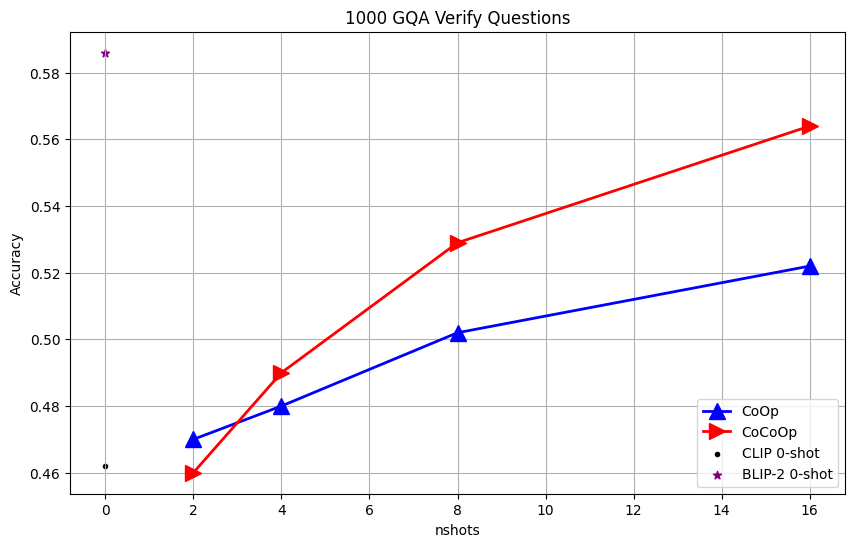

In [ ]:
import matplotlib.pyplot as plt

nshots = [2,4,8,16]
zero_shot = 0.462
coop = [0.47, 0.48, 0.502, 0.522]
cocoop = [0.46, 0.49, 0.529, 0.564]
blip2 = 0.586

plt.figure(figsize=(10,6))
plt.plot(nshots, coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.plot(nshots,cocoop, color='red', marker=">", linestyle='solid',linewidth=2, markersize=12,label="CoCoOp")
plt.scatter([0],zero_shot,color='black',marker=".",label="CLIP 0-shot")
plt.scatter([0],blip2,color='purple',marker="*",label="BLIP-2 0-shot")
plt.legend()
plt.title('1000 GQA Verify Questions')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()

# Plot for Logical

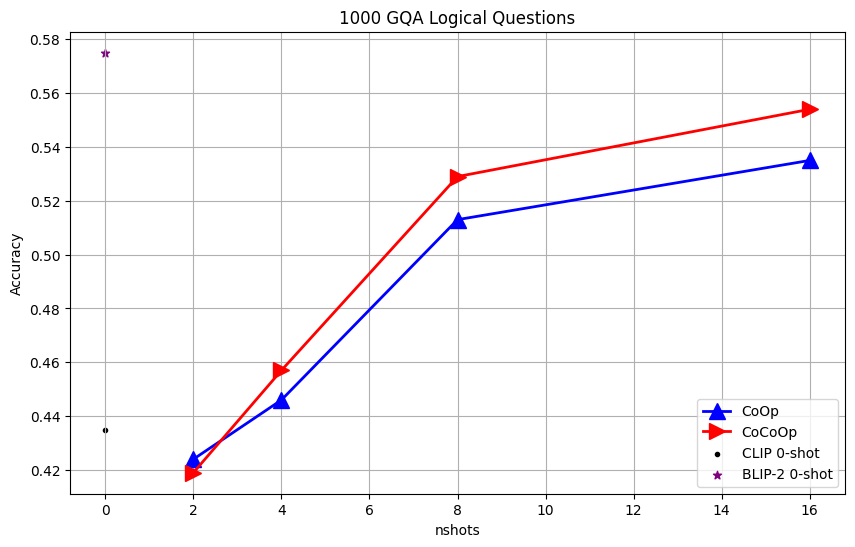

In [ ]:
import matplotlib.pyplot as plt

nshots = [2,4,8,16]
zero_shot = 0.435
coop = [0.424, 0.446, 0.513, 0.535]
cocoop = [0.419, 0.457, 0.529, 0.554]
blip2 = 0.575

plt.figure(figsize=(10,6))
plt.plot(nshots, coop, color='blue', marker="^", linestyle='solid',linewidth=2, markersize=12,label="CoOp")
plt.plot(nshots,cocoop, color='red', marker=">", linestyle='solid',linewidth=2, markersize=12,label="CoCoOp")
plt.scatter([0],zero_shot,color='black',marker=".",label="CLIP 0-shot")
plt.scatter([0],blip2,color='purple',marker="*",label="BLIP-2 0-shot")
plt.legend()
plt.title('1000 GQA Logical Questions')
plt.ylabel('Accuracy')
plt.xlabel('nshots')
plt.grid()
plt.show()